In [ ]:
# default_exp cell_data
from nbdev import *

%reload_ext autoreload
%autoreload 2

# Manage cell data
> Create cells from source data

## Creating cells

As set out in Kerr, we choose binning in time to group photons into "cells". For each cell, we determine its likelihood function, which is then used to estimate the signal rate for that duration.

Eqn. 2 of Kerr shows the log likelihood as a sum of cells of the log likelihoods of the cells, where the $k^{th}$ cell's likelihood,  (with $\beta=0$), is

$$ \displaystyle\log\mathcal{L}_k(\alpha)\ = \sum_{w}  \log \big( 1 + \alpha\ w \big) - \alpha\ f_k\ S   $$

The sum is over the weights $w$ in that cell, and $S$ is an estimate of the signal rate, and $f_k$ is the total exposure for that $k^{th}$ cell. Note that $f_k$ can be expressed as the sum of the exposures per photon, accumulated over the live time, which is from the start of the run or the previous photon. 

*Fermi* data is broken into distinct runs, corresponding at most to a single orbit. The effective area, $\frac{df}{dt}$ varies by a factor of 2 or 3 for each 90-min orbit, is typically  $ 3 000\ \mathrm{cm}^2$, or $0.3\ \mathrm{m^2}$ for $fermi$. This is measured in 30-s intervals.

We'll call the exposure per photon $\tau$ to emphasize that it plays the role of time. 

 So for the $i^{th}$ photon,   
$$\displaystyle\log\mathcal{L}_i(\alpha) = \log( 1 + \alpha\ w_i) - \alpha\  \tau_i\ S  $$

This corresponds to an exponential distribution in $\tau$.

In [ ]:
# export
import os
import numpy as np
import pandas as pd
from wtlike.config import *
from wtlike.source_data import *
from wtlike.loglike import LogLike, PoissonRep

In [ ]:
# export  
def time_bin_edges(config, exposure, tbin=None):
    """Return an interleaved array of start/stop values
    
    tbin: an array (a,b,d), default config.time_bins
    
    interpretation of a, b:

        if > 50000, interpret as MJD
        if <0, back from stop
        otherwise, offset from start
        
    d : if positive, the day bin size
        if 0; return contiguous bins
        

    """
    # nominal total range, MJD edges
    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])

    a, b, step = tbin if tbin is not None else config.time_bins
    

    if a>50000: start=a
    elif a<0: start = stop+a
    else : start += a


    if b>50000: stop=b
    elif b>0: stop = start+b
    else: stop += b
    
    if step<=0:
        return contiguous_bins(exposure.query(f'{start}<start<{stop}'),)

    # adjust stop
    nbins = int((stop-start)/step)
    assert nbins>0, 'Bad binning: no bins'
    stop = start+(nbins)*step
    u =  np.linspace(start,stop, nbins+1 )
    
    # make an interleaved start/stop array
    v = np.empty(2*nbins, float)
    v[0::2] = u[:-1]
    v[1::2] = u[1:]
    return v

# export
def binned_exposure(config, exposure, time_edges):
    """Bin the exposure

    - time_bins: list of edges, as an interleaved start/stop array
       
        
    returns  array of exposure integrated over each time bin, times 1e-9
    it is interleaved, client must apply [0::2] selection.

    """

    # get exposure calculation
    exp   =exposure.exp.values
    estart= exposure.start.values
    estop = exposure.stop.values

    # determine bins,

    #use cumulative exposure to integrate over larger periods
    cumexp = np.concatenate(([0],np.cumsum(exp)) )

    # get index into tstop array of the bin edges
    edge_index = np.searchsorted(estop, time_edges)
    
    # return the exposure integrated over the intervals
    cum = cumexp[edge_index]
   
    # difference is exposure per interval: normalize it here
    bexp = np.diff(cum) 
#     if config.verbose>1:
#         print(f'Relative exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
    return bexp
#export
def contiguous_bins(exposure, min_gap=20, min_duration=600):
    
    """ return a start/stop interleaved array for contiguous intervals
    
    """

    stop = exposure.stop.values
    start = exposure.start.values

    # interleave  the starts and stops
    ssint = np.empty(2*len(start))
    ssint[0::2] = start
    ssint[1::2] = stop

    # Tag the (stpp,start) pairs < 10 sec as  not adjacent
    not_adjacent = np.diff(ssint)[1::2] > min_gap/(24*3600) ; 
    #print(f'{sum(not_adjacent)} (start,stop) pairs are not closer than {min_gap} s')

    # make a mask, keep ends
    mask = np.empty(2*len(start), bool)
    mask[0] = mask[-1] = True
    # 

    # insert into mask -- keep only the (stop,start) pairs  which are not adjacent
    mask[1:-2:2] = not_adjacent
    mask[2:-1:2] = not_adjacent
    
    # apply mask, split into start and stop
    keep = ssint[mask]
    return keep

In [ ]:
# export

class CellData(SourceData):
    """Manage a set of cells generated from a data set
    
        Invoke superclass to load photon data and exposure for the source.
 
        * time_bins, default config.time_bins
        
        
        Note that the `e`  cell entry is the actual exposure for the cell in units $cm^2\ s$, times $10^{-6}$.
        """
    
    def __init__(self, *pars, **kwargs): 
        """

        """
        bins = kwargs.pop('bins', kwargs.pop('time_bins', Config().time_bins))
        #  load source data
        super().__init__(*pars, **kwargs )


        self.rebin(bins)
        self.parent = None

    def rebin(self, newbins):
        """bin, or rebin 
        """
        photon_data = self.photons
        self.time_bins = newbins
        self.cell_edges = edges = time_bin_edges(self.config, self.exposure, newbins)
        if self.config.verbose>0:
            step = newbins[2]
            self.step_name = 'orbit-based' if step<=0 else bin_size_name(step)
            print(f'CellData: Bin photon data into {int(len(edges)/2)} {self.step_name}'\
                  f' bins from {edges[0]:.1f} to {edges[-1]:.1f}')
        
        # note need to take care of interleave
        self.binexp = self.binned_exposure( edges ) [0::2] 
        
        
#         #self.fexposure=(expose/self.exptot).astype(np.float32)
#         self.fexposure = expose 
        
        self.get_cells()
        
    def get_cells(self, exposure_factor=1e-6):
        """
        Generate the cell DataFrame
        
        - exposure_factor --  recast exposure as cm^2 * Ms if $10^{-6}$ 
        
        Thus the `e`  cell entry is the actual exposure for the cell in units $cm^2\ Ms$.
        """
        # restrict photons to range of bin times
        photons = self.photons.query(f'{self.cell_edges[0]}<time<{self.cell_edges[-1]}')
        
        # use photon times to get indices into photon list
        edges = np.searchsorted(photons.time, self.cell_edges)
        
        wts = photons.weight.values
        start,stop = self.cell_edges[0::2], self.cell_edges[1::2]
        center = (start+stop)/2
        width = (stop-start)
        cells = []
        ek = np.append(edges[0::2], edges[-1])
        etot = self.exptot*exposure_factor

        Sk, Bk = self.S/etot, self.B/etot

        for k, (t, tw, e) in enumerate( zip(
                    center, width, self.binexp*exposure_factor) ):
            w = wts[ek[k]:ek[k+1]] 
            n = len(w)
            cells.append(dict(t=t, tw=tw, 
                              e=e,
                              n=n,
                              w=w,
                              S=e*Sk,
                              B=e*Bk,
                             )
                        )
        self.cells =  pd.DataFrame(cells)
        return self.cells

    def update(self): pass # virtual
    
    def view(self, *pars):
        """Return a "view": a new instance of this class with a perhaps a different set of cells
        
        - pars -- start, stop, step  to define new binning. Or start, step, or just step
           start and stop are either MJD values, or offsets from the start or stop.
           step -- the cell size in days, or if zero, orbit-based binning
        """
        import copy
        if self.config.verbose>1:
            print(f'Making a view of the class {self.__class__}')
        r = copy.copy(self)
        

        if len(pars)==3:
            newbins = pars
        elif len(pars)==2: # new limits, same interval
            newbins = (pars[0], pars[1], self.time_bins[0])
        elif len(pars)==1:
            if type(pars[0])==tuple:
                newbins = pars[0]
            else:
                newbins = (self.time_bins[0], self.time_bins[1], pars[0])
        else:
            newbins=None
            
        if newbins is not None:
            r.rebin(newbins)
        r.parent = self
        r.update()
        return r

  
    #### needs fixxing    
    #     def __repr__(self):
    #         return f'''{self.__class__}:
    #         {len(self.fexposure)} intervals from {self.cell_edges[0]:.1f} to {self.cell_edges[-1]:.1f} for source {self.source_name}
    #         S {self.S:.2f}  B {self.B:.2f} '''

    
    def concatenate( self ):
        """
        Combine this set of cells to one
        Return a dict with summed n, S, B, and concatenated w
        """

        cells = self.cells
        
        newcell = dict()

        if 't' in cells:
            ca, cb =cells.iloc[0], cells.iloc[-1]
            newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

        for col in ' n S B'.split():
            newcell[col] = cells[col].sum()
        newcell['w'] = np.concatenate(list(cells.w.values))
        return newcell
    
        
    def full_likelihood(self ):
        """Concatentate all the cells, return a LogLike object
        """
        return LogLike(self.concatenate()) 
    
    def plot_concatenated(self, fignum=1, **kwargs):
        """Likelihood function, with fit for concatenated data
        """
        import matplotlib.pyplot as plt
        lka = self.full_likelihood()
        fig,ax = plt.subplots(figsize=(4,2), num=fignum)
        lka.plot(ax=ax, **kwargs) 
        return fig

In [ ]:
show_doc(CellData)
show_doc(CellData.view)

<h2 id="CellData" class="doc_header"><code>class</code> <code>CellData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>CellData</code>(**\*`pars`**, **\*\*`kwargs`**) :: [`SourceData`](/wtlikesource_data#SourceData)

Manage a set of cells generated from a data set

Invoke superclass to load photon data and exposure for the source.

* time_bins, default config.time_bins


Note that the `e`  cell entry is the actual exposure for the cell in units $cm^2\ s$, times $10^{-6}$.

<h4 id="CellData.view" class="doc_header"><code>CellData.view</code><a href="__main__.py#L88" class="source_link" style="float:right">[source]</a></h4>

> <code>CellData.view</code>(**\*`pars`**)

Return a "view": a new instance of this class with a perhaps a different set of cells

- pars -- start, stop, step  to define new binning. Or start, step, or just step
   start and stop are either MJD values, or offsets from the start or stop.
   step -- the cell size in days, or if zero, orbit-based binning

In [ ]:
# export
def concatenate_cells( cells):
    """
    Combine a group of cells to one
    - cells: dataframe with cells containing  n, w, S, B<br>
            Optionally, if $t$ is present, generate t and tw
    Return a dict with summed n, S, B, and concatenated w
    """
    newcell = dict()
    if 't' in cells:
        ca, cb =cells.iloc[0], cells.iloc[-1]
        newcell.update(dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2), tw=cb.t-ca.t ))

    for col in ' n S B'.split():
        newcell[col] = cells[col].sum()
    newcell['w'] = np.concatenate(list(cells.w.values))
    return newcell

In [ ]:
# export
def partition_cells(config, cells, edges):
    """ Partition a set of cells
     - cells -- A DataFrame of cells
     - edges  -- a list of edge times delimiting boundaries between cells
     
    Returns a DataFrame of combined cells, with times and widths adjusted to account for missing cells
    
    """
    # get indices of  cell idexes just beyond each edge time
    ii = np.searchsorted(cells.t, edges)
    
    # Get the appropriate boundary times to apply to combined cells
    # this is complicated by missing cells, need to put boundary in gaps if ncessary
    ileft = ii[:-1]
    cleft = cells.iloc[ileft ]
    tleft =  (cleft.t - cleft.tw/2).values
    iright = ii[1:]-1
    cright = cells.iloc[iright ]  
    tright = (cright.t+cright.tw/2).values
    betweens = 0.5*(tleft[1:] + tright[:-1])
    tboundary = np.append(np.insert(betweens, 0, tleft[0]), tright[-1])
    
    # now combine the cells, 
    newcells = []
    for k in range(len(ii)-1):
        a,b = ii[k:k+2]
        subset = cells.iloc[a:b]; 

#         ca, cb = subset.iloc[0], subset.iloc[-1]
#         newcell = dict(t= 0.5*(ca.t-ca.tw/2 + cb.t+cb.tw/2)  )
        tl, tr = tboundary[k:k+2]
        newcell = dict(t=0.5*(tl+tr), tw=tr-tl)
        
        for col in 'e n S B'.split():
            newcell[col] = subset[col].sum()
        newcell['e'] /= len(subset)
        newcell['w'] = np.concatenate(list(subset.w.values)) #np.array(w, np.uint8)
        newcells.append(newcell)
    return pd.DataFrame(newcells)      

In [ ]:
show_doc(partition_cells)

<h4 id="partition_cells" class="doc_header"><code>partition_cells</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>partition_cells</code>(**`config`**, **`cells`**, **`edges`**)

Partition a set of cells
 - cells -- A DataFrame of cells
 - edges  -- a list of edge times delimiting boundaries between cells
 
Returns a DataFrame of combined cells, with times and widths adjusted to account for missing cells

## Study cell formation with Geminga

In [ ]:
# hide
config=Config(); config.verbose=2
source = PointSource('Geminga')
cd = CellData(source, config=config, week_range=(9,10), key=None);#clear=True)

	Loading weeks slice(9, 10, None)
SourceData: Assembling photon data and exposure for source Geminga
	from folder "/home/burnett/wtlike_data/data_files", with 670 files,
	Weights from file Geminga_weights.pkl
	Found 4,970 S/C entries:  1,907 remain after zenith and theta cuts
Calculate exposure using the energy domain 100.0-1000000.0 5 bins/decade
WeightMan: file "/home/burnett/wtlike_data/weight_files/Geminga_weights.pkl" : new format, 16 bamds with nsides 64 to 1024
WeightMan: processing 1,310 photons
	596 events without weight
	Found 16,826 S/C entries:  5,633 remain after zenith and theta cuts
Calculate exposure using the energy domain 100.0-1000000.0 5 bins/decade
WeightMan: file "/home/burnett/wtlike_data/weight_files/Geminga_weights.pkl" : new format, 16 bamds with nsides 64 to 1024
WeightMan: processing 3,866 photons
	1,709 events without weight

SourceData: Source Geminga with:
	 data:         2,871 photons from 2008-08-04 to 2008-08-14
	 exposure:     7,540 intervals,  averag

Parmeters from Poisson fit to full data set
flux                     1
ts                 5.2e+03
errors    (0.027, -0.0266)
limit                    1
dtype: object


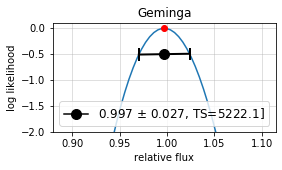

In [ ]:
cd.plot_concatenated( title=f'{cd.source.name}');
print('Parmeters from Poisson fit to full data set')
L = cd.full_likelihood()
pr = PoissonRep(L)
print(pd.Series(pr.info()))

#(cd.cells.n/cd.cells.e).describe()

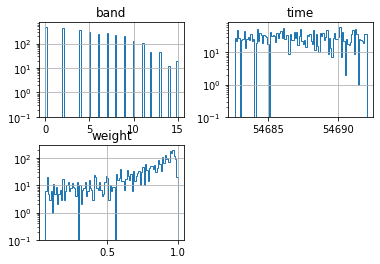

In [ ]:
cd.photons.hist( bins=101, log=True);#np.linspace(0,50,101));

In [ ]:
cd.photons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2871 entries, 0 to 5175
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   band    2871 non-null   uint8  
 1   time    2871 non-null   float64
 2   weight  2871 non-null   float64
dtypes: float64(2), uint8(1)
memory usage: 70.1 KB


In [ ]:
wt = (cd.photons.weight.values).astype(np.float16) 
pd.Series(wt-cd.photons.weight).describe()

count    2.87e+03
mean     5.43e-06
std      1.34e-04
min     -2.44e-04
25%     -9.85e-05
50%      6.85e-06
75%      1.16e-04
max      2.44e-04
Name: weight, dtype: float64

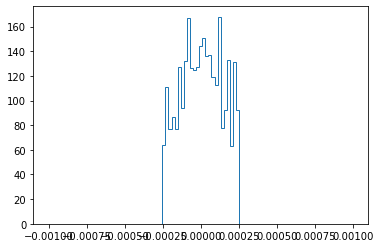

In [ ]:
plt.hist(wt-cd.photons.weight, bins=np.linspace(-0.001, 0.001, 100));

In [ ]:
# hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_weights.ipynb.
Converted 04_exposure.ipynb.
Converted 04_select_data.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90_main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Sun Jun  6 05:52:07 PDT 2021
